In [1]:
# initialized package & connection to DBA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg

# read pwd string from save file
with open('postgrest_pwd.txt', 'r') as f:
    pwd = f.readline()

# read data from table to datatframe with Month form 201801
table = 'mis_cc_kpi_m'
with pg.connect(database='ktc', user='postgres', password=pwd) as con:
    oss = pd.read_sql('select * from ' + table + ' where "month"::bigint >= 201801 and channel = \'OSS\'', con = con)

In [2]:
# EDA on age and 1st spending days
# EDA on age
print(oss['age'].describe())

count    106172.000000
mean         33.039163
std           8.801666
min         -76.000000
25%          26.000000
50%          31.000000
75%          38.000000
max          82.000000
Name: age, dtype: float64


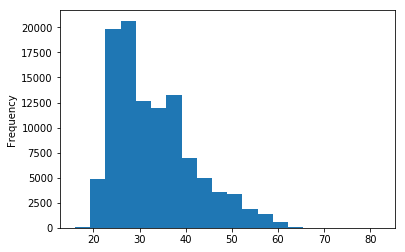

In [17]:
# exclude outliner age < 15
%matplotlib inline
oss.loc[oss.age > 15]['age'].plot.hist(bins = 20)

In [18]:
# EDA on 1st spending day
print(oss['no_transaction_date'].describe())

count    25474.000000
mean        24.846392
std         22.693406
min          0.000000
25%         10.000000
50%         17.000000
75%         31.000000
max        158.000000
Name: no_transaction_date, dtype: float64


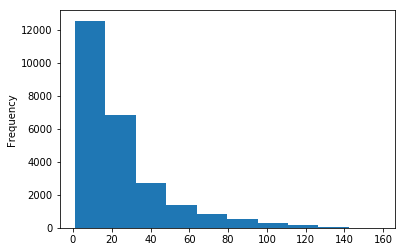

In [19]:
oss.loc[oss.no_transaction_date > 0]['no_transaction_date'].plot.hist()

In [47]:
# K-means clustering on age and 1st spending day
# import package
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns

df = oss.loc[(oss.age >= 15) & (oss.no_transaction_date > 0)][['age', 'no_transaction_date']]
# standardized data to mean = 0, varience = 1
df_scale = scale(df)
# kmeans fit data
kmeans = KMeans(n_clusters=5).fit(df_scale)
# assign segment to df for ploting
df['segment'] = kmeans.labels_

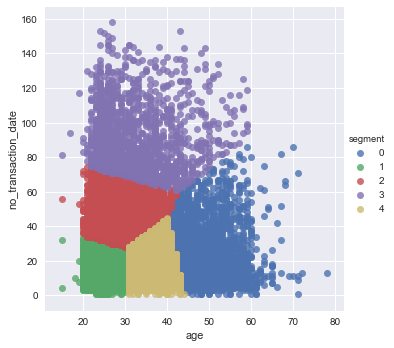

In [53]:
# activate seaborn style
sns.set()
sns.lmplot(x = 'age', y = 'no_transaction_date', data = df,
          hue = 'segment', fit_reg = False)
# plt.scatter(df['age'], df['no_transaction_date'], c = kmeans.labels_, cmap = 'viridis')